<a href="https://colab.research.google.com/github/cincysam6/CMSAC_2024/blob/main/Pressure_Probability_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyarrow scikit-learn xgboost pandas matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 6.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cudnn-cu12==8.9.2.26; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requ

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import optuna
import re as re
warnings.filterwarnings('ignore')


In [ ]:
# Read the parquet file
pressure_prob_df = pd.read_parquet('/content/drive/MyDrive/CMSAC_2024/pressure_model_feat_df.parquet')


In [ ]:
pressure_prob_df.head()

,gameId,week,playId,frameId,second_since_snap,nflId,is_pressure,x,y,s,...,blocker_x_3,blocker_y_1,blocker_y_2,blocker_y_3,qb_dist_from_los,rush_dist_from_los,blocker_1_dist_from_los,blocker_2_dist_from_los,blocker_3_dist_from_los,blocker_interference
0,2021090900,1,97,6,0.0,41263.0,1.0,43.30,18.89,0.96,...,42.10,21.31,22.63,24.02,-5.36,0.30,-1.89,-1.59,-0.90,1.298841
1,2021090900,1,97,6,0.0,42403.0,1.0,43.90,32.63,0.37,...,42.10,26.92,25.65,24.02,-5.36,0.90,-1.62,-1.07,-0.90,0.344543
2,2021090900,1,97,6,0.0,44955.0,0.0,43.35,25.18,0.56,...,41.38,25.65,24.02,26.92,-5.36,0.35,-1.07,-0.90,-1.62,2.131176
3,2021090900,1,97,6,0.0,53441.0,1.0,43.68,21.93,0.36,...,41.11,22.63,24.02,21.31,-5.36,0.68,-1.59,-0.90,-1.89,1.473624
4,2021090900,1,97,6,0.0,53504.0,1.0,43.70,26.67,0.03,...,42.10,25.65,26.92,24.02,-5.36,0.70,-1.07,-1.62,-0.90,1.490285


In [ ]:
### Set Display Options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [ ]:
print(pressure_prob_df.columns.tolist())

['gameId', 'week', 'playId', 'frameId', 'second_since_snap', 'nflId', 'is_pressure', 'x', 'y', 's', 'o', 'dir', 'a', 'qb_x', 'qb_y', 'qb_s', 'qb_a', 'qb_o', 'qb_dir', 'rel_o', 'rel_s', 'rush_qb_dist', 'qb_dist_near_sideline', 'approach_angle', 'blk_rush_dist_1', 'blk_rush_dist_2', 'blk_rush_dist_3', 'blocker_o_1', 'blocker_o_2', 'blocker_o_3', 'blocker_dir_1', 'blocker_dir_2', 'blocker_dir_3', 'blocker_s_1', 'blocker_s_2', 'blocker_s_3', 'leverage_angle_1', 'leverage_angle_2', 'leverage_angle_3', 'xpass', 'ydstogo', 'down', 'defendersInBox', 'blocker_x_1', 'blocker_x_2', 'blocker_x_3', 'blocker_y_1', 'blocker_y_2', 'blocker_y_3', 'qb_dist_from_los', 'rush_dist_from_los', 'blocker_1_dist_from_los', 'blocker_2_dist_from_los', 'blocker_3_dist_from_los', 'blocker_interference']


In [ ]:
pressure_prob_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1326524 entries, 0 to 1326523
Data columns (total 55 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   gameId                   1326524 non-null  int32  
 1   week                     1326524 non-null  int32  
 2   playId                   1326524 non-null  int32  
 3   frameId                  1326524 non-null  int32  
 4   second_since_snap        1326524 non-null  float64
 5   nflId                    1326524 non-null  float64
 6   is_pressure              1326524 non-null  float64
 7   x                        1326524 non-null  float64
 8   y                        1326524 non-null  float64
 9   s                        1326524 non-null  float64
 10  o                        1326524 non-null  float64
 11  dir                      1326524 non-null  float64
 12  a                        1326524 non-null  float64
 13  qb_x                     1326524 non-null 

In [ ]:
model_df = pressure_prob_df.copy()

In [ ]:
model_df.columns

Index(['gameId', 'week', 'playId', 'frameId', 'second_since_snap', 'nflId',
       'is_pressure', 'x', 'y', 's', 'o', 'dir', 'a', 'qb_x', 'qb_y', 'qb_s',
       'qb_a', 'qb_o', 'qb_dir', 'rel_o', 'rel_s', 'rush_qb_dist',
       'qb_dist_near_sideline', 'approach_angle', 'blk_rush_dist_1',
       'blk_rush_dist_2', 'blk_rush_dist_3', 'blocker_o_1', 'blocker_o_2',
       'blocker_o_3', 'blocker_dir_1', 'blocker_dir_2', 'blocker_dir_3',
       'blocker_s_1', 'blocker_s_2', 'blocker_s_3', 'leverage_angle_1',
       'leverage_angle_2', 'leverage_angle_3', 'xpass', 'ydstogo', 'down',
       'defendersInBox', 'blocker_x_1', 'blocker_x_2', 'blocker_x_3',
       'blocker_y_1', 'blocker_y_2', 'blocker_y_3', 'qb_dist_from_los',
       'rush_dist_from_los', 'blocker_1_dist_from_los',
       'blocker_2_dist_from_los', 'blocker_3_dist_from_los',
       'blocker_interference'],
      dtype='object')

In [ ]:
model_df.head()

,gameId,week,playId,frameId,second_since_snap,nflId,is_pressure,x,y,s,o,dir,a,qb_x,qb_y,qb_s,qb_a,qb_o,qb_dir,rel_o,rel_s,rush_qb_dist,qb_dist_near_sideline,approach_angle,blk_rush_dist_1,blk_rush_dist_2,blk_rush_dist_3,blocker_o_1,blocker_o_2,blocker_o_3,blocker_dir_1,blocker_dir_2,blocker_dir_3,blocker_s_1,blocker_s_2,blocker_s_3,leverage_angle_1,leverage_angle_2,leverage_angle_3,xpass,ydstogo,down,defendersInBox,blocker_x_1,blocker_x_2,blocker_x_3,blocker_y_1,blocker_y_2,blocker_y_3,qb_dist_from_los,rush_dist_from_los,blocker_1_dist_from_los,blocker_2_dist_from_los,blocker_3_dist_from_los,blocker_interference
0,2021090900,1,97,6,0.0,41263.0,1.0,43.30,18.89,0.96,316.48,288.76,0.90,37.64,24.26,0.35,0.53,144.42,282.72,172.06,0.61,7.802083,24.26,-0.759112,3.263817,4.190430,5.268482,54.53,106.86,48.28,211.91,303.88,308.34,0.33,0.03,0.51,4.362276,19.696428,33.340275,0.792874,2.0,3,6.0,41.11,41.41,42.10,21.31,22.63,24.02,-5.36,0.30,-1.89,-1.59,-0.90,1.298841
1,2021090900,1,97,6,0.0,42403.0,1.0,43.90,32.63,0.37,278.77,247.75,2.44,37.64,24.26,0.35,0.53,144.42,282.72,134.35,0.02,10.452009,24.26,0.928635,6.241354,7.252675,8.796141,145.19,107.08,48.28,283.52,250.84,308.34,0.85,0.00,0.51,12.979798,21.032231,24.985008,0.792874,2.0,3,6.0,41.38,41.93,42.10,26.92,25.65,24.02,-5.36,0.90,-1.62,-1.07,-0.90,0.344543
2,2021090900,1,97,6,0.0,44955.0,0.0,43.35,25.18,0.56,243.27,288.42,2.42,37.64,24.26,0.35,0.53,144.42,282.72,98.85,0.21,5.783641,24.26,0.159748,1.495761,1.705315,2.628403,107.08,48.28,145.19,250.84,308.34,283.52,0.00,0.51,0.85,27.466699,33.708435,50.605393,0.792874,2.0,3,6.0,41.93,42.10,41.38,25.65,24.02,26.92,-5.36,0.35,-1.07,-0.90,-1.62,2.131176
3,2021090900,1,97,6,0.0,53441.0,1.0,43.68,21.93,0.36,277.16,316.78,2.85,37.64,24.26,0.35,0.53,144.42,282.72,132.74,0.01,6.473832,24.26,-0.368172,2.375479,2.620019,2.643728,106.86,48.28,54.53,303.88,308.34,211.91,0.03,0.51,0.33,3.956504,31.816718,34.657869,0.792874,2.0,3,6.0,41.41,42.10,41.11,22.63,24.02,21.31,-5.36,0.68,-1.59,-0.90,-1.89,1.473624
4,2021090900,1,97,6,0.0,53504.0,1.0,43.70,26.67,0.03,31.86,345.84,0.18,37.64,24.26,0.35,0.53,144.42,282.72,112.56,-0.32,6.521633,24.26,0.378513,2.042866,2.333431,3.095561,107.08,145.19,48.28,250.84,283.52,308.34,0.00,0.85,0.51,8.266399,27.837591,37.190320,0.792874,2.0,3,6.0,41.93,41.38,42.10,25.65,26.92,24.02,-5.36,0.70,-1.07,-1.62,-0.90,1.490285


In [ ]:
model_df['week'].unique()

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)

In [ ]:
model_df = model_df.dropna()

In [ ]:
model_df['game_play_id'] = model_df['gameId'].astype(str) + "_" + model_df['playId'].astype(str)


In [ ]:
model_df.isnull().sum()


,0
gameId,0
week,0
playId,0
frameId,0
second_since_snap,0
nflId,0
is_pressure,0
x,0
y,0
s,0


In [ ]:
# Split the data
test = model_df[model_df['week'] > 6].copy()

train = model_df[model_df['week'] <= 6].copy()


# Columns to remove
cols_to_remove = ["is_pressure", "gameId",'playId', "week", "frameId","nflId"]


In [ ]:
# Prepare training and test data
train_data = train.drop(cols_to_remove, axis=1)
train_labels = train['is_pressure']

test_data = test.drop(cols_to_remove, axis=1)
test_labels = test['is_pressure']

In [ ]:
print(train_data.columns.tolist())

['second_since_snap', 'x', 'y', 's', 'o', 'dir', 'a', 'qb_x', 'qb_y', 'qb_s', 'qb_a', 'qb_o', 'qb_dir', 'rel_o', 'rel_s', 'rush_qb_dist', 'qb_dist_near_sideline', 'approach_angle', 'blk_rush_dist_1', 'blk_rush_dist_2', 'blk_rush_dist_3', 'blocker_o_1', 'blocker_o_2', 'blocker_o_3', 'blocker_dir_1', 'blocker_dir_2', 'blocker_dir_3', 'blocker_s_1', 'blocker_s_2', 'blocker_s_3', 'leverage_angle_1', 'leverage_angle_2', 'leverage_angle_3', 'xpass', 'ydstogo', 'down', 'defendersInBox', 'blocker_x_1', 'blocker_x_2', 'blocker_x_3', 'blocker_y_1', 'blocker_y_2', 'blocker_y_3', 'qb_dist_from_los', 'rush_dist_from_los', 'blocker_1_dist_from_los', 'blocker_2_dist_from_los', 'blocker_3_dist_from_los', 'blocker_interference', 'game_play_id']


In [ ]:
X_train = train_data.drop(columns=['game_play_id'])
y_train = train_labels

In [ ]:
X_train.dtypes

,0
second_since_snap,float64
x,float64
y,float64
s,float64
o,float64
dir,float64
a,float64
qb_x,float64
qb_y,float64
qb_s,float64


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1019187 entries, 0 to 1024225
Data columns (total 49 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   second_since_snap        1019187 non-null  float64
 1   x                        1019187 non-null  float64
 2   y                        1019187 non-null  float64
 3   s                        1019187 non-null  float64
 4   o                        1019187 non-null  float64
 5   dir                      1019187 non-null  float64
 6   a                        1019187 non-null  float64
 7   qb_x                     1019187 non-null  float64
 8   qb_y                     1019187 non-null  float64
 9   qb_s                     1019187 non-null  float64
 10  qb_a                     1019187 non-null  float64
 11  qb_o                     1019187 non-null  float64
 12  qb_dir                   1019187 non-null  float64
 13  rel_o                    1019187 non-null  floa

In [ ]:
X_train_cols = X_train.columns.tolist()

In [ ]:
y_train.info()



<class 'pandas.core.series.Series'>
Index: 1019187 entries, 0 to 1024225
Series name: is_pressure
Non-Null Count    Dtype  
--------------    -----  
1019187 non-null  float64
dtypes: float64(1)
memory usage: 15.6 MB


In [ ]:
from sklearn.metrics import average_precision_score

def objective(trial):

    # Assume `df` is your DataFrame containing all the features
    feature_names = X_train_cols

    # Define the feature that needs a monotonic constraint
    feature_to_constrain = 'rush_qb_dist'

    # Create the monotonic constraints dictionary
    # Set -1 for 'rush_qb_dist' and 0 for all others
    monotone_constraints = {feature: -1 if feature == feature_to_constrain else 0 for feature in feature_names}

    # Define the XGBoost parameters
    # Suggest values for the hyperparameters
    param = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',  # Precision-Recall AUC
        'lambda': trial.suggest_loguniform('lambda', 0.01, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 0.01, 10.0),
        'eta': trial.suggest_loguniform('eta', 0.01, 0.2),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),
        'subsample': trial.suggest_float('subsample', 0.3, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.8),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 15),
        'monotone_constraints': monotone_constraints,  # Add monotonic constraint
        'tree_method': "hist",
        'device': "cuda",
        'predictor': 'gpu_predictor'
    }

    # Assuming train_data and train_labels are pre-defined
    X_train = train_data.drop(columns=['week'])  # Drop the 'week' column as it's used for grouping
    y_train = train_labels
    groups = train_data['week']

    # Leave-One-Week-Out Cross Validation
    logo = LeaveOneGroupOut()
    pr_auc_list = []

    for train_index, test_index in logo.split(X_train, y_train, groups):
        X_train_k, X_val_k = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_k, y_val_k = y_train.iloc[train_index], y_train.iloc[test_index]

        # Ensure no leakage by performing feature engineering within the CV loop
        # For example, normalization or scaling should be done here
        # Example: Standardization within each fold
        #scaler = StandardScaler()
        #X_train_k = scaler.fit_transform(X_train_k)
        #X_val_k = scaler.transform(X_val_k)

        dtrain_k = xgb.DMatrix(X_train_k, label=y_train_k)
        dval_k = xgb.DMatrix(X_val_k, label=y_val_k)

        # Train the model with early stopping
        bst = xgb.train(param, dtrain_k, num_boost_round=2500, evals=[(dval_k, "validation")], early_stopping_rounds=100, verbose_eval=50)
        preds = bst.predict(dval_k)

        # Calculate PR AUC
        pr_auc = average_precision_score(y_val_k, preds)
        pr_auc_list.append(pr_auc)

    # Average PR AUC over all folds
    avg_pr_auc = np.mean(pr_auc_list)

    return avg_pr_auc


In [ ]:
from sklearn.model_selection import GroupKFold
def objective(trial):

    # Assume `df` is your DataFrame containing all the features
    feature_names = X_train_cols

    # Define the feature that needs a monotonic constraint
    feature_to_constrain = 'rush_qb_dist'

    # Create the monotonic constraints dictionary
    # Set -1 for 'rush_qb_dist' and 0 for all others
    monotone_constraints = {feature: -1 if feature == feature_to_constrain else 0 for feature in feature_names}

    # Define the XGBoost parameters with adjusted ranges to mitigate overfitting
    param = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',  # Precision-Recall AUC

        # Adjusting ranges for regularization
        'lambda': trial.suggest_loguniform('lambda', 1, 100.0),  # Increased upper bound for stronger regularization
        'alpha': trial.suggest_loguniform('alpha', 1, 100.0),    # Increased upper bound for stronger regularization

        # Reduce learning rate and increase `num_boost_round` to allow the model to learn more gradually
        'eta': trial.suggest_loguniform('eta', 0.001, 0.05),  # Lower learning rate for more gradual learning

        # Regularization parameter gamma to control complexity
        'gamma': trial.suggest_float('gamma', 1.0, 10.0),  # Increased minimum for stronger regularization

        # Adjust subsample and colsample_bytree to introduce randomness
        'subsample': trial.suggest_float('subsample', 0.5, 0.9),  # Larger lower bound to ensure sufficient sampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),  # Larger lower bound for more features per tree

        # Max depth and min child weight to control the complexity of trees
        'max_depth': trial.suggest_int('max_depth', 3, 8),  # Reduced maximum depth to limit tree complexity
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 20),  # Increased lower bound to control the number of instances in each node

        'monotone_constraints': monotone_constraints,  # Add monotonic constraint
        'tree_method': "hist",
        'device': "cuda",
        'predictor': 'gpu_predictor'
    }

    # Assuming train_data and train_labels are pre-defined
    X_train = train_data.drop(columns=['game_play_id'])  # Drop the 'game_play_id' column
    y_train = train_labels
    groups = train_data['game_play_id']  # Group by 'game_play_id'

    # 5-Fold Cross Validation grouped by 'game_play_id'
    kf = GroupKFold(n_splits=5)
    pr_auc_list = []

    for train_index, test_index in kf.split(X_train, y_train, groups=groups):
        X_train_k, X_val_k = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_k, y_val_k = y_train.iloc[train_index], y_train.iloc[test_index]

        # Ensure no leakage by performing feature engineering within the CV loop

        # Example: Standardization within each fold (uncomment if needed)
        # scaler = StandardScaler()
        # X_train_k = scaler.fit_transform(X_train_k)
        # X_val_k = scaler.transform(X_val_k)

        dtrain_k = xgb.DMatrix(X_train_k, label=y_train_k)
        dval_k = xgb.DMatrix(X_val_k, label=y_val_k)

        # Train the model with early stopping
        bst = xgb.train(param, dtrain_k, num_boost_round=2500, evals=[(dval_k, "validation")], early_stopping_rounds=100, verbose_eval=50)
        preds = bst.predict(dval_k)

        # Calculate PR AUC
        pr_auc = average_precision_score(y_val_k, preds)
        pr_auc_list.append(pr_auc)

    # Average PR AUC over all folds
    avg_pr_auc = np.mean(pr_auc_list)

    return avg_pr_auc

In [ ]:

# Create a study object and specify the direction of optimization
study = optuna.create_study(direction='maximize')  # We want to maximize the PR AUC

# Optimize the objective function using the study
study.optimize(objective, n_trials=25)  # You can adjust n_trials based on how thorough you want the search to be

# Retrieve the best trial
best_trial = study.best_trial
best_params = best_trial.params

# Output the results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', best_params)
print('Best trial value (PR AUC):', best_trial.value)


[I 2024-08-15 18:01:38,559] A new study created in memory with name: no-name-ab758771-9b65-45d1-963b-f6739a27c7bf


[0]	validation-aucpr:0.40900
[50]	validation-aucpr:0.48334
[100]	validation-aucpr:0.49520
[150]	validation-aucpr:0.50509
[200]	validation-aucpr:0.51172
[250]	validation-aucpr:0.51720
[300]	validation-aucpr:0.52047
[350]	validation-aucpr:0.52217
[400]	validation-aucpr:0.52462
[450]	validation-aucpr:0.52608
[500]	validation-aucpr:0.52685
[550]	validation-aucpr:0.52792
[600]	validation-aucpr:0.52861
[650]	validation-aucpr:0.52920
[700]	validation-aucpr:0.53004
[750]	validation-aucpr:0.53051
[800]	validation-aucpr:0.53086
[850]	validation-aucpr:0.53134
[900]	validation-aucpr:0.53132
[950]	validation-aucpr:0.53162
[1000]	validation-aucpr:0.53206
[1050]	validation-aucpr:0.53232
[1100]	validation-aucpr:0.53254
[1150]	validation-aucpr:0.53248
[1200]	validation-aucpr:0.53253
[1250]	validation-aucpr:0.53258
[1300]	validation-aucpr:0.53240
[1330]	validation-aucpr:0.53220
[0]	validation-aucpr:0.43323
[50]	validation-aucpr:0.50608
[100]	validation-aucpr:0.51766
[150]	validation-aucpr:0.52728
[200]	

[I 2024-08-15 18:07:18,221] Trial 0 finished with value: 0.5428622450572554 and parameters: {'lambda': 11.116101641031193, 'alpha': 3.8090545799421647, 'eta': 0.02278750704994117, 'gamma': 3.0679049589205443, 'subsample': 0.5845129802296946, 'colsample_bytree': 0.5783096923573192, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.38771
[50]	validation-aucpr:0.45117
[100]	validation-aucpr:0.46047
[150]	validation-aucpr:0.46864
[200]	validation-aucpr:0.47572
[250]	validation-aucpr:0.48164
[300]	validation-aucpr:0.48519
[350]	validation-aucpr:0.48812
[400]	validation-aucpr:0.49107
[450]	validation-aucpr:0.49357
[500]	validation-aucpr:0.49586
[550]	validation-aucpr:0.49791
[600]	validation-aucpr:0.49962
[650]	validation-aucpr:0.50092
[700]	validation-aucpr:0.50205
[750]	validation-aucpr:0.50319
[800]	validation-aucpr:0.50435
[850]	validation-aucpr:0.50540
[900]	validation-aucpr:0.50629
[950]	validation-aucpr:0.50739
[1000]	validation-aucpr:0.50856
[1050]	validation-aucpr:0.50904
[1100]	validation-aucpr:0.50958
[1150]	validation-aucpr:0.51013
[1200]	validation-aucpr:0.51076
[1250]	validation-aucpr:0.51149
[1300]	validation-aucpr:0.51188
[1350]	validation-aucpr:0.51237
[1400]	validation-aucpr:0.51297
[1450]	validation-aucpr:0.51339
[1500]	validation-aucpr:0.51395
[1550]	validation-aucpr:0.51443

[I 2024-08-15 18:15:48,700] Trial 1 finished with value: 0.5305048350089232 and parameters: {'lambda': 58.91671819813382, 'alpha': 1.0009944709776928, 'eta': 0.015253323875472085, 'gamma': 2.2011050840203565, 'subsample': 0.8521771720001512, 'colsample_bytree': 0.6034207157012527, 'max_depth': 4, 'min_child_weight': 14}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.40557
[50]	validation-aucpr:0.45168
[100]	validation-aucpr:0.46241
[150]	validation-aucpr:0.47185
[200]	validation-aucpr:0.48057
[250]	validation-aucpr:0.48759
[300]	validation-aucpr:0.49211
[350]	validation-aucpr:0.49553
[400]	validation-aucpr:0.49881
[450]	validation-aucpr:0.50138
[500]	validation-aucpr:0.50354
[550]	validation-aucpr:0.50533
[600]	validation-aucpr:0.50727
[650]	validation-aucpr:0.50864
[700]	validation-aucpr:0.51016
[750]	validation-aucpr:0.51128
[800]	validation-aucpr:0.51248
[850]	validation-aucpr:0.51366
[900]	validation-aucpr:0.51424
[950]	validation-aucpr:0.51511
[1000]	validation-aucpr:0.51576
[1050]	validation-aucpr:0.51640
[1100]	validation-aucpr:0.51682
[1150]	validation-aucpr:0.51742
[1200]	validation-aucpr:0.51788
[1250]	validation-aucpr:0.51845
[1300]	validation-aucpr:0.51900
[1350]	validation-aucpr:0.51975
[1400]	validation-aucpr:0.52027
[1450]	validation-aucpr:0.52086
[1500]	validation-aucpr:0.52148
[1550]	validation-aucpr:0.52183

[I 2024-08-15 18:24:51,325] Trial 2 finished with value: 0.5369381328038203 and parameters: {'lambda': 1.115434653287184, 'alpha': 2.679454496160606, 'eta': 0.012194402199053786, 'gamma': 6.996463463813126, 'subsample': 0.6332727084771304, 'colsample_bytree': 0.8510039944393288, 'max_depth': 5, 'min_child_weight': 11}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.40426
[50]	validation-aucpr:0.48545
[100]	validation-aucpr:0.50028
[150]	validation-aucpr:0.50896
[200]	validation-aucpr:0.51465
[250]	validation-aucpr:0.51843
[300]	validation-aucpr:0.52105
[350]	validation-aucpr:0.52282
[400]	validation-aucpr:0.52413
[450]	validation-aucpr:0.52510
[500]	validation-aucpr:0.52631
[550]	validation-aucpr:0.52702
[600]	validation-aucpr:0.52763
[650]	validation-aucpr:0.52784
[700]	validation-aucpr:0.52820
[750]	validation-aucpr:0.52810
[796]	validation-aucpr:0.52814
[0]	validation-aucpr:0.41983
[50]	validation-aucpr:0.51016
[100]	validation-aucpr:0.52564
[150]	validation-aucpr:0.53198
[200]	validation-aucpr:0.53632
[250]	validation-aucpr:0.53985
[300]	validation-aucpr:0.54145
[350]	validation-aucpr:0.54277
[400]	validation-aucpr:0.54366
[450]	validation-aucpr:0.54367
[500]	validation-aucpr:0.54427
[550]	validation-aucpr:0.54451
[600]	validation-aucpr:0.54481
[650]	validation-aucpr:0.54441
[700]	validation-aucpr:0.54415
[705]	validati

[I 2024-08-15 18:28:12,063] Trial 3 finished with value: 0.5392866633262917 and parameters: {'lambda': 53.698455898877185, 'alpha': 5.899630620245211, 'eta': 0.04470577552773164, 'gamma': 8.4853103636175, 'subsample': 0.7377806163762448, 'colsample_bytree': 0.5574466371267264, 'max_depth': 6, 'min_child_weight': 18}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.38938
[50]	validation-aucpr:0.45828
[100]	validation-aucpr:0.47804
[150]	validation-aucpr:0.48697
[200]	validation-aucpr:0.49338
[250]	validation-aucpr:0.49823
[300]	validation-aucpr:0.50141
[350]	validation-aucpr:0.50402
[400]	validation-aucpr:0.50582
[450]	validation-aucpr:0.50836
[500]	validation-aucpr:0.51003
[550]	validation-aucpr:0.51128
[600]	validation-aucpr:0.51242
[650]	validation-aucpr:0.51344
[700]	validation-aucpr:0.51475
[750]	validation-aucpr:0.51581
[800]	validation-aucpr:0.51690
[850]	validation-aucpr:0.51724
[900]	validation-aucpr:0.51807
[950]	validation-aucpr:0.51872
[1000]	validation-aucpr:0.51910
[1050]	validation-aucpr:0.51927
[1100]	validation-aucpr:0.51978
[1150]	validation-aucpr:0.52012
[1200]	validation-aucpr:0.52055
[1250]	validation-aucpr:0.52087
[1300]	validation-aucpr:0.52112
[1350]	validation-aucpr:0.52156
[1400]	validation-aucpr:0.52209
[1450]	validation-aucpr:0.52231
[1500]	validation-aucpr:0.52259
[1550]	validation-aucpr:0.52256

[I 2024-08-15 18:34:11,221] Trial 4 finished with value: 0.5337743622997111 and parameters: {'lambda': 23.617934514086375, 'alpha': 28.291171674628828, 'eta': 0.03522366623596151, 'gamma': 8.117228157537344, 'subsample': 0.5345936550468345, 'colsample_bytree': 0.8400499737118765, 'max_depth': 4, 'min_child_weight': 11}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.41304
[50]	validation-aucpr:0.46136
[100]	validation-aucpr:0.46669
[150]	validation-aucpr:0.47118
[200]	validation-aucpr:0.47399
[250]	validation-aucpr:0.47653
[300]	validation-aucpr:0.47868
[350]	validation-aucpr:0.48040
[400]	validation-aucpr:0.48195
[450]	validation-aucpr:0.48371
[500]	validation-aucpr:0.48561
[550]	validation-aucpr:0.48728
[600]	validation-aucpr:0.48902
[650]	validation-aucpr:0.49069
[700]	validation-aucpr:0.49256
[750]	validation-aucpr:0.49423
[800]	validation-aucpr:0.49574
[850]	validation-aucpr:0.49711
[900]	validation-aucpr:0.49853
[950]	validation-aucpr:0.50000
[1000]	validation-aucpr:0.50131
[1050]	validation-aucpr:0.50264
[1100]	validation-aucpr:0.50390
[1150]	validation-aucpr:0.50511
[1200]	validation-aucpr:0.50620
[1250]	validation-aucpr:0.50735
[1300]	validation-aucpr:0.50840
[1350]	validation-aucpr:0.50939
[1400]	validation-aucpr:0.51024
[1450]	validation-aucpr:0.51107
[1500]	validation-aucpr:0.51187
[1550]	validation-aucpr:0.51260

[I 2024-08-15 18:47:40,378] Trial 5 finished with value: 0.5340707451723675 and parameters: {'lambda': 47.24452090807067, 'alpha': 31.877684473524045, 'eta': 0.0030937763221903394, 'gamma': 3.6439237095676296, 'subsample': 0.7926527805125136, 'colsample_bytree': 0.7415525221417562, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.41169
[50]	validation-aucpr:0.46032
[100]	validation-aucpr:0.46368
[150]	validation-aucpr:0.46515
[200]	validation-aucpr:0.46682
[250]	validation-aucpr:0.46797
[300]	validation-aucpr:0.46841
[350]	validation-aucpr:0.46922
[400]	validation-aucpr:0.46999
[450]	validation-aucpr:0.47073
[500]	validation-aucpr:0.47157
[550]	validation-aucpr:0.47250
[600]	validation-aucpr:0.47343
[650]	validation-aucpr:0.47419
[700]	validation-aucpr:0.47550
[750]	validation-aucpr:0.47643
[800]	validation-aucpr:0.47711
[850]	validation-aucpr:0.47770
[900]	validation-aucpr:0.47842
[950]	validation-aucpr:0.47924
[1000]	validation-aucpr:0.47988
[1050]	validation-aucpr:0.48046
[1100]	validation-aucpr:0.48106
[1150]	validation-aucpr:0.48163
[1200]	validation-aucpr:0.48203
[1250]	validation-aucpr:0.48264
[1300]	validation-aucpr:0.48319
[1350]	validation-aucpr:0.48381
[1400]	validation-aucpr:0.48454
[1450]	validation-aucpr:0.48524
[1500]	validation-aucpr:0.48577
[1550]	validation-aucpr:0.48630

[I 2024-08-15 19:02:18,717] Trial 6 finished with value: 0.5122119184250146 and parameters: {'lambda': 36.90370959995349, 'alpha': 7.336990424460688, 'eta': 0.0010790577509636951, 'gamma': 2.347381114339984, 'subsample': 0.540885186904958, 'colsample_bytree': 0.7931765993987274, 'max_depth': 8, 'min_child_weight': 16}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.38510
[50]	validation-aucpr:0.43900
[100]	validation-aucpr:0.44166
[150]	validation-aucpr:0.44351
[200]	validation-aucpr:0.44481
[250]	validation-aucpr:0.44566
[300]	validation-aucpr:0.44701
[350]	validation-aucpr:0.44787
[400]	validation-aucpr:0.44896
[450]	validation-aucpr:0.45003
[500]	validation-aucpr:0.45099
[550]	validation-aucpr:0.45181
[600]	validation-aucpr:0.45274
[650]	validation-aucpr:0.45372
[700]	validation-aucpr:0.45461
[750]	validation-aucpr:0.45557
[800]	validation-aucpr:0.45634
[850]	validation-aucpr:0.45713
[900]	validation-aucpr:0.45802
[950]	validation-aucpr:0.45890
[1000]	validation-aucpr:0.45970
[1050]	validation-aucpr:0.46076
[1100]	validation-aucpr:0.46177
[1150]	validation-aucpr:0.46267
[1200]	validation-aucpr:0.46345
[1250]	validation-aucpr:0.46443
[1300]	validation-aucpr:0.46526
[1350]	validation-aucpr:0.46610
[1400]	validation-aucpr:0.46704
[1450]	validation-aucpr:0.46793
[1500]	validation-aucpr:0.46875
[1550]	validation-aucpr:0.46954

[I 2024-08-15 19:11:14,885] Trial 7 finished with value: 0.4932948918274036 and parameters: {'lambda': 94.04407307657682, 'alpha': 2.1666643298033677, 'eta': 0.0016708035927976322, 'gamma': 4.592325616413791, 'subsample': 0.8293594889746502, 'colsample_bytree': 0.6626215700730094, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.41796
[50]	validation-aucpr:0.47342
[100]	validation-aucpr:0.47654
[150]	validation-aucpr:0.47993
[200]	validation-aucpr:0.48186
[250]	validation-aucpr:0.48332
[300]	validation-aucpr:0.48497
[350]	validation-aucpr:0.48683
[400]	validation-aucpr:0.48845
[450]	validation-aucpr:0.49017
[500]	validation-aucpr:0.49191
[550]	validation-aucpr:0.49364
[600]	validation-aucpr:0.49496
[650]	validation-aucpr:0.49643
[700]	validation-aucpr:0.49832
[750]	validation-aucpr:0.49974
[800]	validation-aucpr:0.50091
[850]	validation-aucpr:0.50234
[900]	validation-aucpr:0.50383
[950]	validation-aucpr:0.50524
[1000]	validation-aucpr:0.50653
[1050]	validation-aucpr:0.50776
[1100]	validation-aucpr:0.50882
[1150]	validation-aucpr:0.50979
[1200]	validation-aucpr:0.51070
[1250]	validation-aucpr:0.51162
[1300]	validation-aucpr:0.51241
[1350]	validation-aucpr:0.51326
[1400]	validation-aucpr:0.51408
[1450]	validation-aucpr:0.51490
[1500]	validation-aucpr:0.51567
[1550]	validation-aucpr:0.51630

[I 2024-08-15 19:23:15,143] Trial 8 finished with value: 0.53522446911186 and parameters: {'lambda': 1.5967809672058508, 'alpha': 4.708018636176036, 'eta': 0.003281206296065104, 'gamma': 8.351113827515588, 'subsample': 0.7540598548373576, 'colsample_bytree': 0.5306934435177865, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.41598
[50]	validation-aucpr:0.45997
[100]	validation-aucpr:0.46339
[150]	validation-aucpr:0.46579
[200]	validation-aucpr:0.46734
[250]	validation-aucpr:0.46718
[300]	validation-aucpr:0.46806
[350]	validation-aucpr:0.46882
[400]	validation-aucpr:0.46976
[450]	validation-aucpr:0.47061
[500]	validation-aucpr:0.47193
[550]	validation-aucpr:0.47331
[600]	validation-aucpr:0.47463
[650]	validation-aucpr:0.47534
[700]	validation-aucpr:0.47642
[750]	validation-aucpr:0.47712
[800]	validation-aucpr:0.47793
[850]	validation-aucpr:0.47855
[900]	validation-aucpr:0.47920
[950]	validation-aucpr:0.48013
[1000]	validation-aucpr:0.48098
[1050]	validation-aucpr:0.48166
[1100]	validation-aucpr:0.48241
[1150]	validation-aucpr:0.48304
[1200]	validation-aucpr:0.48362
[1250]	validation-aucpr:0.48441
[1300]	validation-aucpr:0.48510
[1350]	validation-aucpr:0.48603
[1400]	validation-aucpr:0.48691
[1450]	validation-aucpr:0.48795
[1500]	validation-aucpr:0.48895
[1550]	validation-aucpr:0.48976

[I 2024-08-15 19:38:16,708] Trial 9 finished with value: 0.5172424001437841 and parameters: {'lambda': 2.91299683632076, 'alpha': 3.928887290703528, 'eta': 0.0010537980313108264, 'gamma': 4.318238347765717, 'subsample': 0.5325918023631191, 'colsample_bytree': 0.8775247815988813, 'max_depth': 8, 'min_child_weight': 18}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.40466
[50]	validation-aucpr:0.46888
[100]	validation-aucpr:0.47874
[150]	validation-aucpr:0.48681
[200]	validation-aucpr:0.49355
[250]	validation-aucpr:0.49863
[300]	validation-aucpr:0.50206
[350]	validation-aucpr:0.50529
[400]	validation-aucpr:0.50760
[450]	validation-aucpr:0.50995
[500]	validation-aucpr:0.51165
[550]	validation-aucpr:0.51346
[600]	validation-aucpr:0.51430
[650]	validation-aucpr:0.51586
[700]	validation-aucpr:0.51681
[750]	validation-aucpr:0.51773
[800]	validation-aucpr:0.51884
[850]	validation-aucpr:0.51947
[900]	validation-aucpr:0.52029
[950]	validation-aucpr:0.52094
[1000]	validation-aucpr:0.52170
[1050]	validation-aucpr:0.52220
[1100]	validation-aucpr:0.52284
[1150]	validation-aucpr:0.52325
[1200]	validation-aucpr:0.52361
[1250]	validation-aucpr:0.52392
[1300]	validation-aucpr:0.52427
[1350]	validation-aucpr:0.52465
[1400]	validation-aucpr:0.52488
[1450]	validation-aucpr:0.52515
[1500]	validation-aucpr:0.52540
[1550]	validation-aucpr:0.52567

[I 2024-08-15 19:48:19,700] Trial 10 finished with value: 0.540433117004196 and parameters: {'lambda': 8.21334626844655, 'alpha': 90.44371909196735, 'eta': 0.018406786945596585, 'gamma': 1.0860954573136428, 'subsample': 0.6459498807390762, 'colsample_bytree': 0.6690567651911289, 'max_depth': 6, 'min_child_weight': 16}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.40886
[50]	validation-aucpr:0.47253
[100]	validation-aucpr:0.48435
[150]	validation-aucpr:0.49373
[200]	validation-aucpr:0.50142
[250]	validation-aucpr:0.50658
[300]	validation-aucpr:0.50987
[350]	validation-aucpr:0.51256
[400]	validation-aucpr:0.51504
[450]	validation-aucpr:0.51721
[500]	validation-aucpr:0.51842
[550]	validation-aucpr:0.51985
[600]	validation-aucpr:0.52054
[650]	validation-aucpr:0.52160
[700]	validation-aucpr:0.52260
[750]	validation-aucpr:0.52325
[800]	validation-aucpr:0.52374
[850]	validation-aucpr:0.52440
[900]	validation-aucpr:0.52516
[950]	validation-aucpr:0.52548
[1000]	validation-aucpr:0.52600
[1050]	validation-aucpr:0.52645
[1100]	validation-aucpr:0.52709
[1150]	validation-aucpr:0.52739
[1200]	validation-aucpr:0.52745
[1250]	validation-aucpr:0.52748
[1300]	validation-aucpr:0.52768
[1350]	validation-aucpr:0.52799
[1400]	validation-aucpr:0.52816
[1450]	validation-aucpr:0.52839
[1500]	validation-aucpr:0.52868
[1550]	validation-aucpr:0.52907

[I 2024-08-15 19:56:03,272] Trial 11 finished with value: 0.5411008989209648 and parameters: {'lambda': 8.434437346593572, 'alpha': 17.12119440610302, 'eta': 0.020010625771969225, 'gamma': 1.3800724207036588, 'subsample': 0.65105892083287, 'colsample_bytree': 0.6526562583090765, 'max_depth': 6, 'min_child_weight': 16}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.41110
[50]	validation-aucpr:0.46914
[100]	validation-aucpr:0.47568
[150]	validation-aucpr:0.48190
[200]	validation-aucpr:0.48639
[250]	validation-aucpr:0.48921
[300]	validation-aucpr:0.49247
[350]	validation-aucpr:0.49553
[400]	validation-aucpr:0.49861
[450]	validation-aucpr:0.50149
[500]	validation-aucpr:0.50396
[550]	validation-aucpr:0.50658
[600]	validation-aucpr:0.50866
[650]	validation-aucpr:0.51041
[700]	validation-aucpr:0.51213
[750]	validation-aucpr:0.51341
[800]	validation-aucpr:0.51470
[850]	validation-aucpr:0.51580
[900]	validation-aucpr:0.51663
[950]	validation-aucpr:0.51765
[1000]	validation-aucpr:0.51852
[1050]	validation-aucpr:0.51957
[1100]	validation-aucpr:0.52025
[1150]	validation-aucpr:0.52079
[1200]	validation-aucpr:0.52142
[1250]	validation-aucpr:0.52196
[1300]	validation-aucpr:0.52243
[1350]	validation-aucpr:0.52293
[1400]	validation-aucpr:0.52339
[1450]	validation-aucpr:0.52383
[1500]	validation-aucpr:0.52437
[1550]	validation-aucpr:0.52469

[I 2024-08-15 20:07:48,507] Trial 12 finished with value: 0.5414547095694425 and parameters: {'lambda': 10.947497953315944, 'alpha': 15.792182087541619, 'eta': 0.007005586683155357, 'gamma': 1.0244774125864489, 'subsample': 0.6334745502928405, 'colsample_bytree': 0.6147408604230853, 'max_depth': 7, 'min_child_weight': 15}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.40817
[50]	validation-aucpr:0.47149
[100]	validation-aucpr:0.47592
[150]	validation-aucpr:0.48098
[200]	validation-aucpr:0.48472
[250]	validation-aucpr:0.48758
[300]	validation-aucpr:0.49048
[350]	validation-aucpr:0.49332
[400]	validation-aucpr:0.49614
[450]	validation-aucpr:0.49875
[500]	validation-aucpr:0.50112
[550]	validation-aucpr:0.50369
[600]	validation-aucpr:0.50575
[650]	validation-aucpr:0.50774
[700]	validation-aucpr:0.50968
[750]	validation-aucpr:0.51136
[800]	validation-aucpr:0.51258
[850]	validation-aucpr:0.51391
[900]	validation-aucpr:0.51506
[950]	validation-aucpr:0.51620
[1000]	validation-aucpr:0.51712
[1050]	validation-aucpr:0.51794
[1100]	validation-aucpr:0.51861
[1150]	validation-aucpr:0.51929
[1200]	validation-aucpr:0.51988
[1250]	validation-aucpr:0.52053
[1300]	validation-aucpr:0.52112
[1350]	validation-aucpr:0.52187
[1400]	validation-aucpr:0.52230
[1450]	validation-aucpr:0.52284
[1500]	validation-aucpr:0.52332
[1550]	validation-aucpr:0.52380

[I 2024-08-15 20:19:48,100] Trial 13 finished with value: 0.54044961505573 and parameters: {'lambda': 15.37387259679361, 'alpha': 12.580362585596339, 'eta': 0.006108679236066452, 'gamma': 2.9629062401261193, 'subsample': 0.6042207124777474, 'colsample_bytree': 0.5866256113092732, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.41215
[50]	validation-aucpr:0.47489
[100]	validation-aucpr:0.48064
[150]	validation-aucpr:0.48608
[200]	validation-aucpr:0.49008
[250]	validation-aucpr:0.49351
[300]	validation-aucpr:0.49689
[350]	validation-aucpr:0.50011
[400]	validation-aucpr:0.50336
[450]	validation-aucpr:0.50615
[500]	validation-aucpr:0.50864
[550]	validation-aucpr:0.51090
[600]	validation-aucpr:0.51260
[650]	validation-aucpr:0.51424
[700]	validation-aucpr:0.51561
[750]	validation-aucpr:0.51668
[800]	validation-aucpr:0.51786
[850]	validation-aucpr:0.51884
[900]	validation-aucpr:0.51968
[950]	validation-aucpr:0.52056
[1000]	validation-aucpr:0.52118
[1050]	validation-aucpr:0.52190
[1100]	validation-aucpr:0.52270
[1150]	validation-aucpr:0.52328
[1200]	validation-aucpr:0.52370
[1250]	validation-aucpr:0.52430
[1300]	validation-aucpr:0.52462
[1350]	validation-aucpr:0.52525
[1400]	validation-aucpr:0.52573
[1450]	validation-aucpr:0.52610
[1500]	validation-aucpr:0.52657
[1550]	validation-aucpr:0.52685

[I 2024-08-15 20:31:33,894] Trial 14 finished with value: 0.542290662960013 and parameters: {'lambda': 4.402268505520974, 'alpha': 23.056868467332126, 'eta': 0.008359202607340225, 'gamma': 6.276348388893773, 'subsample': 0.5848206139379539, 'colsample_bytree': 0.5160092276277155, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.41039
[50]	validation-aucpr:0.48225
[100]	validation-aucpr:0.49371
[150]	validation-aucpr:0.50257
[200]	validation-aucpr:0.50864
[250]	validation-aucpr:0.51311
[300]	validation-aucpr:0.51589
[350]	validation-aucpr:0.51826
[400]	validation-aucpr:0.51996
[450]	validation-aucpr:0.52135
[500]	validation-aucpr:0.52283
[550]	validation-aucpr:0.52399
[600]	validation-aucpr:0.52458
[650]	validation-aucpr:0.52513
[700]	validation-aucpr:0.52599
[750]	validation-aucpr:0.52662
[800]	validation-aucpr:0.52692
[850]	validation-aucpr:0.52716
[900]	validation-aucpr:0.52777
[950]	validation-aucpr:0.52806
[1000]	validation-aucpr:0.52817
[1050]	validation-aucpr:0.52814
[1100]	validation-aucpr:0.52823
[1150]	validation-aucpr:0.52821
[1200]	validation-aucpr:0.52837
[1250]	validation-aucpr:0.52850
[1300]	validation-aucpr:0.52860
[1350]	validation-aucpr:0.52863
[1400]	validation-aucpr:0.52861
[1450]	validation-aucpr:0.52881
[1500]	validation-aucpr:0.52882
[1550]	validation-aucpr:0.52888

[I 2024-08-15 20:38:18,545] Trial 15 finished with value: 0.5402913434544176 and parameters: {'lambda': 4.474782331399859, 'alpha': 89.84017944459092, 'eta': 0.02840531550062482, 'gamma': 6.001836919738617, 'subsample': 0.5816768389160073, 'colsample_bytree': 0.5055581652826071, 'max_depth': 7, 'min_child_weight': 10}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.37254
[50]	validation-aucpr:0.43792
[100]	validation-aucpr:0.44176
[150]	validation-aucpr:0.44682
[200]	validation-aucpr:0.45114
[250]	validation-aucpr:0.45520
[300]	validation-aucpr:0.45970
[350]	validation-aucpr:0.46374
[400]	validation-aucpr:0.46696
[450]	validation-aucpr:0.46967
[500]	validation-aucpr:0.47182
[550]	validation-aucpr:0.47370
[600]	validation-aucpr:0.47540
[650]	validation-aucpr:0.47676
[700]	validation-aucpr:0.47848
[750]	validation-aucpr:0.47986
[800]	validation-aucpr:0.48109
[850]	validation-aucpr:0.48219
[900]	validation-aucpr:0.48323
[950]	validation-aucpr:0.48437
[1000]	validation-aucpr:0.48557
[1050]	validation-aucpr:0.48669
[1100]	validation-aucpr:0.48749
[1150]	validation-aucpr:0.48847
[1200]	validation-aucpr:0.48932
[1250]	validation-aucpr:0.49018
[1300]	validation-aucpr:0.49090
[1350]	validation-aucpr:0.49154
[1400]	validation-aucpr:0.49213
[1450]	validation-aucpr:0.49276
[1500]	validation-aucpr:0.49347
[1550]	validation-aucpr:0.49403

[I 2024-08-15 20:46:21,355] Trial 16 finished with value: 0.5128490590772076 and parameters: {'lambda': 4.247819941983037, 'alpha': 33.029930626989064, 'eta': 0.00842915943062572, 'gamma': 9.826647165712394, 'subsample': 0.6880563672428615, 'colsample_bytree': 0.501167541037633, 'max_depth': 3, 'min_child_weight': 13}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.40318
[50]	validation-aucpr:0.45045
[100]	validation-aucpr:0.45616
[150]	validation-aucpr:0.46065
[200]	validation-aucpr:0.46391
[250]	validation-aucpr:0.46642
[300]	validation-aucpr:0.46870
[350]	validation-aucpr:0.47064
[400]	validation-aucpr:0.47275
[450]	validation-aucpr:0.47505
[500]	validation-aucpr:0.47728
[550]	validation-aucpr:0.47935
[600]	validation-aucpr:0.48158
[650]	validation-aucpr:0.48371
[700]	validation-aucpr:0.48592
[750]	validation-aucpr:0.48794
[800]	validation-aucpr:0.48965
[850]	validation-aucpr:0.49114
[900]	validation-aucpr:0.49268
[950]	validation-aucpr:0.49412
[1000]	validation-aucpr:0.49535
[1050]	validation-aucpr:0.49655
[1100]	validation-aucpr:0.49762
[1150]	validation-aucpr:0.49865
[1200]	validation-aucpr:0.49963
[1250]	validation-aucpr:0.50055
[1300]	validation-aucpr:0.50147
[1350]	validation-aucpr:0.50232
[1400]	validation-aucpr:0.50316
[1450]	validation-aucpr:0.50399
[1500]	validation-aucpr:0.50466
[1550]	validation-aucpr:0.50527

[I 2024-08-15 20:56:30,589] Trial 17 finished with value: 0.5261365425743649 and parameters: {'lambda': 2.7458738798577116, 'alpha': 1.418707350575024, 'eta': 0.0041955697657222535, 'gamma': 5.56329062403762, 'subsample': 0.5055741817118193, 'colsample_bytree': 0.7258298923696588, 'max_depth': 5, 'min_child_weight': 18}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.40403
[50]	validation-aucpr:0.47174
[100]	validation-aucpr:0.47810
[150]	validation-aucpr:0.48453
[200]	validation-aucpr:0.48934
[250]	validation-aucpr:0.49325
[300]	validation-aucpr:0.49724
[350]	validation-aucpr:0.50074
[400]	validation-aucpr:0.50373
[450]	validation-aucpr:0.50660
[500]	validation-aucpr:0.50869
[550]	validation-aucpr:0.51086
[600]	validation-aucpr:0.51261
[650]	validation-aucpr:0.51396
[700]	validation-aucpr:0.51529
[750]	validation-aucpr:0.51628
[800]	validation-aucpr:0.51734
[850]	validation-aucpr:0.51840
[900]	validation-aucpr:0.51937
[950]	validation-aucpr:0.52023
[1000]	validation-aucpr:0.52096
[1050]	validation-aucpr:0.52169
[1100]	validation-aucpr:0.52224
[1150]	validation-aucpr:0.52274
[1200]	validation-aucpr:0.52313
[1250]	validation-aucpr:0.52368
[1300]	validation-aucpr:0.52412
[1350]	validation-aucpr:0.52463
[1400]	validation-aucpr:0.52510
[1450]	validation-aucpr:0.52559
[1500]	validation-aucpr:0.52596
[1550]	validation-aucpr:0.52625

[I 2024-08-15 21:08:27,919] Trial 18 finished with value: 0.5414845450153292 and parameters: {'lambda': 20.125899995731757, 'alpha': 54.07340140306796, 'eta': 0.010450832442905502, 'gamma': 6.841883915652996, 'subsample': 0.5735957639699587, 'colsample_bytree': 0.556237964549354, 'max_depth': 7, 'min_child_weight': 14}. Best is trial 0 with value: 0.5428622450572554.


[0]	validation-aucpr:0.41656
[50]	validation-aucpr:0.49172
[100]	validation-aucpr:0.50428
[150]	validation-aucpr:0.51388
[200]	validation-aucpr:0.51980
[250]	validation-aucpr:0.52302
[300]	validation-aucpr:0.52581
[350]	validation-aucpr:0.52730
[400]	validation-aucpr:0.52833
[450]	validation-aucpr:0.52897
[500]	validation-aucpr:0.52965
[550]	validation-aucpr:0.53029
[600]	validation-aucpr:0.53100
[650]	validation-aucpr:0.53156
[700]	validation-aucpr:0.53222
[750]	validation-aucpr:0.53295
[800]	validation-aucpr:0.53368
[850]	validation-aucpr:0.53375
[900]	validation-aucpr:0.53380
[950]	validation-aucpr:0.53388
[968]	validation-aucpr:0.53392
[0]	validation-aucpr:0.43617
[50]	validation-aucpr:0.51237
[100]	validation-aucpr:0.52541
[150]	validation-aucpr:0.53412
[200]	validation-aucpr:0.53907
[250]	validation-aucpr:0.54231
[300]	validation-aucpr:0.54486
[350]	validation-aucpr:0.54627
[400]	validation-aucpr:0.54680
[450]	validation-aucpr:0.54701
[500]	validation-aucpr:0.54759
[550]	validati

[I 2024-08-15 21:13:14,083] Trial 19 finished with value: 0.5436088771499005 and parameters: {'lambda': 5.166708467216247, 'alpha': 8.06443434712598, 'eta': 0.025887142542079276, 'gamma': 4.718826910236977, 'subsample': 0.6868536905677918, 'colsample_bytree': 0.56906450549048, 'max_depth': 8, 'min_child_weight': 12}. Best is trial 19 with value: 0.5436088771499005.


[0]	validation-aucpr:0.41548
[50]	validation-aucpr:0.48923
[100]	validation-aucpr:0.50450
[150]	validation-aucpr:0.51477
[200]	validation-aucpr:0.52039
[250]	validation-aucpr:0.52385
[300]	validation-aucpr:0.52599
[350]	validation-aucpr:0.52799
[400]	validation-aucpr:0.52950
[450]	validation-aucpr:0.53006
[500]	validation-aucpr:0.53081
[550]	validation-aucpr:0.53163
[600]	validation-aucpr:0.53194
[650]	validation-aucpr:0.53260
[700]	validation-aucpr:0.53264
[750]	validation-aucpr:0.53230
[770]	validation-aucpr:0.53216
[0]	validation-aucpr:0.43925
[50]	validation-aucpr:0.51329
[100]	validation-aucpr:0.52785
[150]	validation-aucpr:0.53589
[200]	validation-aucpr:0.54047
[250]	validation-aucpr:0.54361
[300]	validation-aucpr:0.54567
[350]	validation-aucpr:0.54655
[400]	validation-aucpr:0.54659
[450]	validation-aucpr:0.54758
[500]	validation-aucpr:0.54807
[550]	validation-aucpr:0.54841
[600]	validation-aucpr:0.54836
[650]	validation-aucpr:0.54872
[700]	validation-aucpr:0.54859
[750]	validati

[I 2024-08-15 21:17:33,839] Trial 20 finished with value: 0.5435217941908453 and parameters: {'lambda': 13.351896292373102, 'alpha': 8.3168842037937, 'eta': 0.02751891071063341, 'gamma': 4.744266607892282, 'subsample': 0.8934250902163866, 'colsample_bytree': 0.6230860894511331, 'max_depth': 8, 'min_child_weight': 10}. Best is trial 19 with value: 0.5436088771499005.


[0]	validation-aucpr:0.41976
[50]	validation-aucpr:0.48691
[100]	validation-aucpr:0.50109
[150]	validation-aucpr:0.51200
[200]	validation-aucpr:0.51836
[250]	validation-aucpr:0.52239
[300]	validation-aucpr:0.52519
[350]	validation-aucpr:0.52776
[400]	validation-aucpr:0.52890
[450]	validation-aucpr:0.52956
[500]	validation-aucpr:0.53075
[550]	validation-aucpr:0.53154
[600]	validation-aucpr:0.53193
[650]	validation-aucpr:0.53241
[700]	validation-aucpr:0.53280
[750]	validation-aucpr:0.53353
[800]	validation-aucpr:0.53385
[850]	validation-aucpr:0.53394
[900]	validation-aucpr:0.53399
[950]	validation-aucpr:0.53424
[1000]	validation-aucpr:0.53417
[1050]	validation-aucpr:0.53447
[1100]	validation-aucpr:0.53429
[1135]	validation-aucpr:0.53405
[0]	validation-aucpr:0.43999
[50]	validation-aucpr:0.51094
[100]	validation-aucpr:0.52475
[150]	validation-aucpr:0.53340
[200]	validation-aucpr:0.53886
[250]	validation-aucpr:0.54160
[300]	validation-aucpr:0.54350
[350]	validation-aucpr:0.54515
[400]	vali

[I 2024-08-15 21:22:43,844] Trial 21 finished with value: 0.5440751218590891 and parameters: {'lambda': 11.375793048847846, 'alpha': 9.34017516748167, 'eta': 0.024147623204101486, 'gamma': 4.662221753392893, 'subsample': 0.8867547671033109, 'colsample_bytree': 0.6334962614187974, 'max_depth': 8, 'min_child_weight': 10}. Best is trial 21 with value: 0.5440751218590891.


[0]	validation-aucpr:0.41989
[50]	validation-aucpr:0.50084
[100]	validation-aucpr:0.51824
[150]	validation-aucpr:0.52468
[200]	validation-aucpr:0.52742
[250]	validation-aucpr:0.52813
[300]	validation-aucpr:0.52884
[350]	validation-aucpr:0.52901
[400]	validation-aucpr:0.52852
[450]	validation-aucpr:0.52894
[460]	validation-aucpr:0.52907
[0]	validation-aucpr:0.43973
[50]	validation-aucpr:0.52547
[100]	validation-aucpr:0.53948
[150]	validation-aucpr:0.54389
[200]	validation-aucpr:0.54619
[250]	validation-aucpr:0.54758
[300]	validation-aucpr:0.54767
[350]	validation-aucpr:0.54612
[367]	validation-aucpr:0.54632
[0]	validation-aucpr:0.43092
[50]	validation-aucpr:0.51668
[100]	validation-aucpr:0.53443
[150]	validation-aucpr:0.53976
[200]	validation-aucpr:0.54211
[250]	validation-aucpr:0.54431
[300]	validation-aucpr:0.54599
[350]	validation-aucpr:0.54619
[400]	validation-aucpr:0.54664
[450]	validation-aucpr:0.54729
[500]	validation-aucpr:0.54699
[550]	validation-aucpr:0.54653
[566]	validation-

[I 2024-08-15 21:25:24,146] Trial 22 finished with value: 0.541312478968648 and parameters: {'lambda': 7.130355484575337, 'alpha': 8.4230047015534, 'eta': 0.0496259155601026, 'gamma': 4.79173361695155, 'subsample': 0.8974532470061704, 'colsample_bytree': 0.6337814572099889, 'max_depth': 8, 'min_child_weight': 10}. Best is trial 21 with value: 0.5440751218590891.


[0]	validation-aucpr:0.41407
[50]	validation-aucpr:0.48697
[100]	validation-aucpr:0.50453
[150]	validation-aucpr:0.51524
[200]	validation-aucpr:0.51980
[250]	validation-aucpr:0.52351
[300]	validation-aucpr:0.52525
[350]	validation-aucpr:0.52726
[400]	validation-aucpr:0.52808
[450]	validation-aucpr:0.52882
[500]	validation-aucpr:0.52963
[550]	validation-aucpr:0.53037
[600]	validation-aucpr:0.53003
[647]	validation-aucpr:0.53020
[0]	validation-aucpr:0.44177
[50]	validation-aucpr:0.51328
[100]	validation-aucpr:0.52843
[150]	validation-aucpr:0.53682
[200]	validation-aucpr:0.54067
[250]	validation-aucpr:0.54334
[300]	validation-aucpr:0.54551
[350]	validation-aucpr:0.54701
[400]	validation-aucpr:0.54740
[450]	validation-aucpr:0.54747
[500]	validation-aucpr:0.54800
[550]	validation-aucpr:0.54802
[600]	validation-aucpr:0.54836
[650]	validation-aucpr:0.54868
[700]	validation-aucpr:0.54878
[750]	validation-aucpr:0.54810
[797]	validation-aucpr:0.54805
[0]	validation-aucpr:0.42556
[50]	validation-

[I 2024-08-15 21:29:08,472] Trial 23 finished with value: 0.5417791728801055 and parameters: {'lambda': 15.05516030406664, 'alpha': 8.221879081627257, 'eta': 0.0288934092991576, 'gamma': 5.213664447270518, 'subsample': 0.8775795826885325, 'colsample_bytree': 0.6913217790211313, 'max_depth': 8, 'min_child_weight': 11}. Best is trial 21 with value: 0.5440751218590891.


[0]	validation-aucpr:0.41909
[50]	validation-aucpr:0.48079
[100]	validation-aucpr:0.49053
[150]	validation-aucpr:0.49862
[200]	validation-aucpr:0.50489
[250]	validation-aucpr:0.51013
[300]	validation-aucpr:0.51451
[350]	validation-aucpr:0.51796
[400]	validation-aucpr:0.52016
[450]	validation-aucpr:0.52191
[500]	validation-aucpr:0.52343
[550]	validation-aucpr:0.52477
[600]	validation-aucpr:0.52566
[650]	validation-aucpr:0.52670
[700]	validation-aucpr:0.52750
[750]	validation-aucpr:0.52794
[800]	validation-aucpr:0.52844
[850]	validation-aucpr:0.52910
[900]	validation-aucpr:0.52942
[950]	validation-aucpr:0.53000
[1000]	validation-aucpr:0.53028
[1050]	validation-aucpr:0.53067
[1100]	validation-aucpr:0.53097
[1150]	validation-aucpr:0.53116
[1200]	validation-aucpr:0.53127
[1250]	validation-aucpr:0.53134
[1300]	validation-aucpr:0.53146
[1350]	validation-aucpr:0.53134
[1380]	validation-aucpr:0.53133
[0]	validation-aucpr:0.44054
[50]	validation-aucpr:0.50456
[100]	validation-aucpr:0.51486
[150]

[I 2024-08-15 21:36:46,180] Trial 24 finished with value: 0.5436821354666821 and parameters: {'lambda': 6.110540710044251, 'alpha': 12.156370746616792, 'eta': 0.013530416710569237, 'gamma': 3.7880088628492117, 'subsample': 0.8169520152793717, 'colsample_bytree': 0.6235265876673876, 'max_depth': 8, 'min_child_weight': 10}. Best is trial 21 with value: 0.5440751218590891.


Number of finished trials: 25
Best trial parameters: {'lambda': 11.375793048847846, 'alpha': 9.34017516748167, 'eta': 0.024147623204101486, 'gamma': 4.662221753392893, 'subsample': 0.8867547671033109, 'colsample_bytree': 0.6334962614187974, 'max_depth': 8, 'min_child_weight': 10}
Best trial value (PR AUC): 0.5440751218590891


In [ ]:
X_train.head()

,second_since_snap,x,y,s,o,dir,a,qb_x,qb_y,qb_s,qb_a,qb_o,qb_dir,rel_o,rel_s,rush_qb_dist,qb_dist_near_sideline,approach_angle,blk_rush_dist_1,blk_rush_dist_2,blk_rush_dist_3,blocker_o_1,blocker_o_2,blocker_o_3,blocker_dir_1,blocker_dir_2,blocker_dir_3,blocker_s_1,blocker_s_2,blocker_s_3,leverage_angle_1,leverage_angle_2,leverage_angle_3,xpass,ydstogo,down,defendersInBox,blocker_x_1,blocker_x_2,blocker_x_3,blocker_y_1,blocker_y_2,blocker_y_3,qb_dist_from_los,rush_dist_from_los,blocker_1_dist_from_los,blocker_2_dist_from_los,blocker_3_dist_from_los,blocker_interference
0,0.0,43.30,18.89,0.96,316.48,288.76,0.90,37.64,24.26,0.35,0.53,144.42,282.72,172.06,0.61,7.802083,24.26,-0.759112,3.263817,4.190430,5.268482,54.53,106.86,48.28,211.91,303.88,308.34,0.33,0.03,0.51,4.362276,19.696428,33.340275,0.792874,2.0,3,6.0,41.11,41.41,42.10,21.31,22.63,24.02,-5.36,0.30,-1.89,-1.59,-0.90,1.298841
1,0.0,43.90,32.63,0.37,278.77,247.75,2.44,37.64,24.26,0.35,0.53,144.42,282.72,134.35,0.02,10.452009,24.26,0.928635,6.241354,7.252675,8.796141,145.19,107.08,48.28,283.52,250.84,308.34,0.85,0.00,0.51,12.979798,21.032231,24.985008,0.792874,2.0,3,6.0,41.38,41.93,42.10,26.92,25.65,24.02,-5.36,0.90,-1.62,-1.07,-0.90,0.344543
2,0.0,43.35,25.18,0.56,243.27,288.42,2.42,37.64,24.26,0.35,0.53,144.42,282.72,98.85,0.21,5.783641,24.26,0.159748,1.495761,1.705315,2.628403,107.08,48.28,145.19,250.84,308.34,283.52,0.00,0.51,0.85,27.466699,33.708435,50.605393,0.792874,2.0,3,6.0,41.93,42.10,41.38,25.65,24.02,26.92,-5.36,0.35,-1.07,-0.90,-1.62,2.131176
3,0.0,43.68,21.93,0.36,277.16,316.78,2.85,37.64,24.26,0.35,0.53,144.42,282.72,132.74,0.01,6.473832,24.26,-0.368172,2.375479,2.620019,2.643728,106.86,48.28,54.53,303.88,308.34,211.91,0.03,0.51,0.33,3.956504,31.816718,34.657869,0.792874,2.0,3,6.0,41.41,42.10,41.11,22.63,24.02,21.31,-5.36,0.68,-1.59,-0.90,-1.89,1.473624
4,0.0,43.70,26.67,0.03,31.86,345.84,0.18,37.64,24.26,0.35,0.53,144.42,282.72,112.56,-0.32,6.521633,24.26,0.378513,2.042866,2.333431,3.095561,107.08,145.19,48.28,250.84,283.52,308.34,0.00,0.85,0.51,8.266399,27.837591,37.190320,0.792874,2.0,3,6.0,41.93,41.38,42.10,25.65,26.92,24.02,-5.36,0.70,-1.07,-1.62,-0.90,1.490285


In [ ]:
   # Assume `df` is your DataFrame containing all the features
feature_names = X_train_cols

    # Define the feature that needs a monotonic constraint
feature_to_constrain = 'rush_qb_dist'

    # Create the monotonic constraints dictionary
    # Set -1 for 'rush_qb_dist' and 0 for all others
monotone_constraints = {feature: -1 if feature == feature_to_constrain else 0 for feature in feature_names}




In [ ]:
best_params

{'lambda': 11.375793048847846,
 'alpha': 9.34017516748167,
 'eta': 0.024147623204101486,
 'gamma': 4.662221753392893,
 'subsample': 0.8867547671033109,
 'colsample_bytree': 0.6334962614187974,
 'max_depth': 8,
 'min_child_weight': 10}

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)

best_params.update({
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'monotone_constraints': monotone_constraints,  # This should be defined as in your initial code
    'tree_method': "hist",
    'device': "cuda",
    'predictor': 'gpu_predictor'
})

print(best_params)

{'lambda': 11.375793048847846, 'alpha': 9.34017516748167, 'eta': 0.024147623204101486, 'gamma': 4.662221753392893, 'subsample': 0.8867547671033109, 'colsample_bytree': 0.6334962614187974, 'max_depth': 8, 'min_child_weight': 10, 'booster': 'gbtree', 'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'monotone_constraints': {'second_since_snap': 0, 'x': 0, 'y': 0, 's': 0, 'o': 0, 'dir': 0, 'a': 0, 'qb_x': 0, 'qb_y': 0, 'qb_s': 0, 'qb_a': 0, 'qb_o': 0, 'qb_dir': 0, 'rel_o': 0, 'rel_s': 0, 'rush_qb_dist': -1, 'qb_dist_near_sideline': 0, 'approach_angle': 0, 'blk_rush_dist_1': 0, 'blk_rush_dist_2': 0, 'blk_rush_dist_3': 0, 'blocker_o_1': 0, 'blocker_o_2': 0, 'blocker_o_3': 0, 'blocker_dir_1': 0, 'blocker_dir_2': 0, 'blocker_dir_3': 0, 'blocker_s_1': 0, 'blocker_s_2': 0, 'blocker_s_3': 0, 'leverage_angle_1': 0, 'leverage_angle_2': 0, 'leverage_angle_3': 0, 'xpass': 0, 'ydstogo': 0, 'down': 0, 'defendersInBox': 0, 'blocker_x_1': 0, 'blocker_x_2': 0, 'blocker_x_3': 0, 'blocker_y_1': 0, 'b

In [ ]:

# Train the model with the best parameters
best_model = xgb.train(best_params, dtrain, num_boost_round=2500)


In [ ]:

# Save the model to a JSON file
best_model.save_model("best_xgb_model.json")

# Alternatively, use pickle to save the entire model object
with open("/content/drive/MyDrive/CMSAC_2024/best_xgb_model.pkl", "wb") as f:
    pickle.dump(best_model, f)


In [ ]:

X_test = test_data.drop(columns=['game_play_id'])
y_test = test_labels
dtest = xgb.DMatrix(X_test, label=y_test)


In [ ]:
# Predictions for train set
train_preds = best_model.predict(dtrain)

# Predictions for test set
test_preds = best_model.predict(dtest)

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate AUC for train and test sets
train_auc = roc_auc_score(y_train, train_preds)
test_auc = roc_auc_score(y_test, test_preds)

print(f'Train AUC: {train_auc:.4f}')
print(f'Test AUC: {test_auc:.4f}')

Train AUC: 0.9485
Test AUC: 0.8176


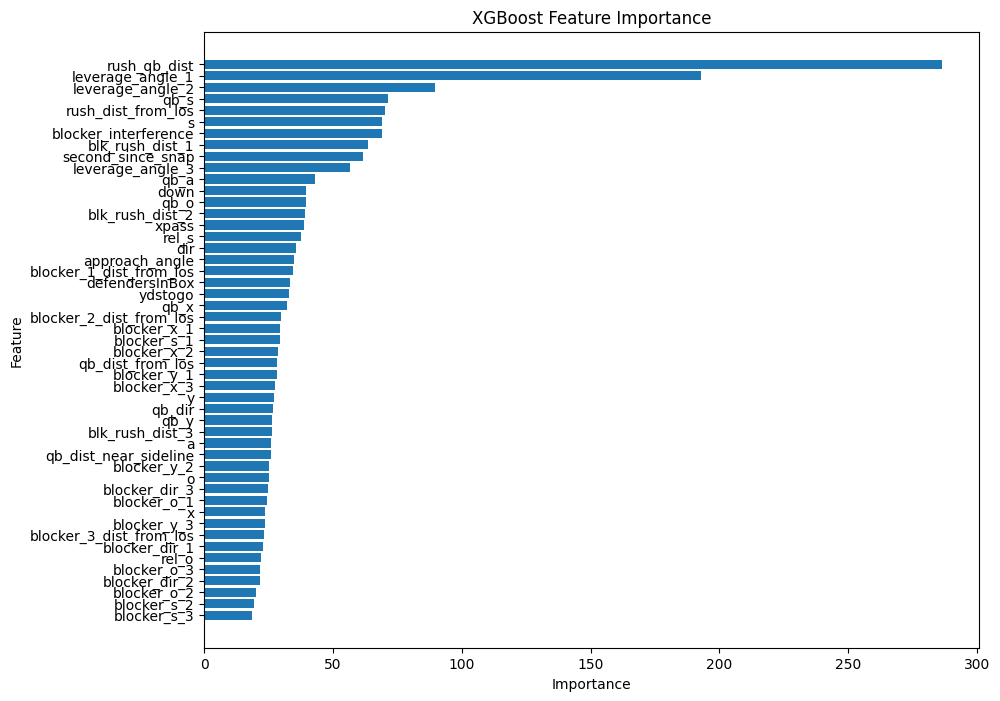

In [ ]:
# Extract feature importance
importance = best_model.get_score(importance_type='gain')

# Convert the feature importance dictionary to a DataFrame
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert predicted probabilities to binary outcomes
train_preds_binary = [1 if x > 0.5 else 0 for x in train_preds]
test_preds_binary = [1 if x > 0.5 else 0 for x in test_preds]

# Accuracy
train_accuracy = accuracy_score(y_train, train_preds_binary)
test_accuracy = accuracy_score(y_test, test_preds_binary)

# Precision, Recall, F1-Score
train_precision = precision_score(y_train, train_preds_binary)
test_precision = precision_score(y_test, test_preds_binary)

train_recall = recall_score(y_train, train_preds_binary)
test_recall = recall_score(y_test, test_preds_binary)

train_f1 = f1_score(y_train, train_preds_binary)
test_f1 = f1_score(y_test, test_preds_binary)

# Confusion Matrix
train_conf_matrix = confusion_matrix(y_train, train_preds_binary)
test_conf_matrix = confusion_matrix(y_test, test_preds_binary)

# Classification Report
test_class_report = classification_report(y_test, test_preds_binary)

# Print all metrics
print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

print(f'Train Precision: {train_precision:.4f}')
print(f'Test Precision: {test_precision:.4f}')

print(f'Train Recall: {train_recall:.4f}')
print(f'Test Recall: {test_recall:.4f}')

print(f'Train F1-Score: {train_f1:.4f}')
print(f'Test F1-Score: {test_f1:.4f}')

print(f'Test Confusion Matrix:\n{test_conf_matrix}')
print(f'Test Classification Report:\n{test_class_report}')


In [ ]:

# If you have binary predictions as well:
train_preds_binary = [1 if x > 0.5 else 0 for x in train_preds]
test_preds_binary = [1 if x > 0.5 else 0 for x in test_preds]

# Convert predictions to DataFrame and make sure they match the index of the original data
train_preds_df = pd.DataFrame({
    'pressure_prob': train_preds,
    'pressure_binary': train_preds_binary
}, index=train.index)

test_preds_df = pd.DataFrame({
    'pressure_prob': test_preds,
    'pressure_binary': test_preds_binary
}, index=test.index)


In [ ]:
# Join the predictions back to the original data
train_with_preds = train.join(train_preds_df)
test_with_preds = test.join(test_preds_df)


In [ ]:
full_preds = pd.concat([train_with_preds, test_with_preds])

In [ ]:
model_df.shape

In [ ]:
full_preds.shape

In [ ]:
full_preds[['is_pressure','gameId','playId','frameId','nflId','pressure_prob']].head(200)

In [ ]:
full_preds.describe()

In [ ]:
full_preds.to_parquet("/content/drive/MyDrive/CMSAC_2024/full_pressure_preds.parquet", index=False)


In [ ]:
best_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'aucpr',  # Precision-Recall AUC
        'lambda': 6.181981560033522,
        'alpha': 0.16077021405884265,
        'eta': 0.012132902810795456,
        'gamma': 2.9075480871541246,
        'subsample':  0.44547553566273457,
        'colsample_bytree': 0.6361585557438802,
        'max_depth':9,
        'min_child_weight': 20,
        'monotone_constraints': monotone_constraints,  # Add monotonic constraint
        'tree_method': "hist",
        'device': "cuda",
        'predictor': 'gpu_predictor'
    }

In [ ]:
{'lambda': 67.69894166378658,
 'alpha': 17.369114231895075,
 'eta': 0.010499478895079005,
 'gamma': 1.7090689205366623,
 'subsample': 0.7969873339217632,
 'colsample_bytree': 0.8291632563853102,
 'max_depth': 7,
 'min_child_weight': 18}